# Data Preprocess

Take into account that all this analysis and preprocess depends on the language that you are working with. In this case, the original dataset is in **English**.

If you receive any error when trying to import `en_core_web_sm`, try executing this command first: `python -m spacy download en_core_web_sm`

In [1]:
import os
import re
import copy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import string
import en_core_web_sm
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS as STOP_WORDS_SET

## Read the dataset

Despite you will find your dataset in a CSV, in this respository the data is stored in a database. Here I have defined a few functions to manage the connection with the database and parse the results.

In [2]:
DATA_PATH = '../data/'

train_file = 'NCBI_corpus_training.txt'
test_file = 'NCBI_corpus_testing.txt'

with open(DATA_PATH + train_file, 'r') as fp:
    train_dataset = fp.readlines()

with open(DATA_PATH + test_file, 'r') as fp:
    test_dataset = fp.readlines()

print('Train texts: %d' % len(train_dataset))
print('Test texts: %d' % len(test_dataset))

Train texts: 593
Test texts: 100


## Preprocess

This is a minimal preprocess, as I do not want to remove any essential information from texts.

In [3]:
def get_nlp_engine(basic_tokenizer=False):
    if basic_tokenizer:
        nlp = English()
    else:
        nlp = en_core_web_sm.load()
    return nlp

The dataset that I am using contains a number in the beginning of every text. Here I remove that number.

In [4]:
def apply_initial_number_remover(texts):
    texts = [re.sub(r'^[0-9]+\s*', '', text) for text in texts]
    return texts

In [5]:
train_dataset = apply_initial_number_remover(train_dataset)
test_dataset = apply_initial_number_remover(test_dataset)

#print(train_dataset[0]) # Sample

Segmentize texts in sentences, i.e. I am going to consider each sentence as an independent sample in the input of the model.

In [6]:
def apply_sentences_split(texts):
    nlp = get_nlp_engine()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    
    sentences = []
    for text in texts:
        t_sentences = nlp(text)
        t_sentences = [s.text.strip() for s in t_sentences.sents if s.text.strip() != '']
        sentences = sentences + t_sentences
    
    return sentences

In [7]:
train_dataset = apply_sentences_split(train_dataset)
test_dataset = apply_sentences_split(test_dataset)

#print(train_dataset[0:5]) # Sample

Before I clean each sentence, I get all tags "*category*" from them, so I can use them **to measure the performance** of my NER algorithm.

In [8]:
"""
Returns a list "text ID -> list of entities" where list of entities
is a list of tuples like "(category name, text in tag)"
"""
def get_entities_in_category_tags(texts):
    entities = []
    for text_id, text in enumerate(texts):
        t_entities = re.findall(r'<category="(.+?)">(.+?)</category>', text)
        entities.append(t_entities)
    
    return entities

In [9]:
train_entities = get_entities_in_category_tags(train_dataset)
test_entities = get_entities_in_category_tags(test_dataset)

#print(train_entities[0]) # Sample

Now, let's **remove the "*category*" tags** as well as **stop words** and **punctuation symbols**. Also, I **normalize words** which contain some capital letters: the first letter will be capitalized and the rest will be in lower cases.

In [10]:
def apply_tag_cleaner(texts):
    texts = texts.copy()
    for index, text in enumerate(texts):
        text = re.sub(r'<category=".+?">', ' ', text)
        text = re.sub(r'</category>', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        texts[index] = text.strip()
    
    return texts

In [11]:
train_dataset = apply_tag_cleaner(train_dataset)
test_dataset = apply_tag_cleaner(test_dataset)

#print(train_dataset[0]) # Sample

Analyze the corpus in two different ways:
- As 1s and 0s, where $1$ indicate that there is an entity and $0$ that it is just a normal word.
- As PoS tags.

In [12]:
def tokenize_texts(texts, basic_tokenizer=False):
    texts = texts.copy()
    nlp = get_nlp_engine(basic_tokenizer=basic_tokenizer)
    
    for index, text in enumerate(texts):
        nlp_tokens = nlp(text)
        
        pos = [w.pos_ for w in nlp_tokens]
        lemmas = [w.lemma_.strip() if w.lemma_ != "-PRON-" else w.lower_.strip() for w in nlp_tokens]
        lemmas = [w if any(c.isupper() for c in w) else w for w in lemmas]
        
        # Remove empty tokens
        tokens = [(lemmas[i].strip(), pos[i], nlp_tokens[i]) for i in range(len(nlp_tokens)) if lemmas[i].strip() != '']
        
        texts[index] = tokens
    
    return texts

In [13]:
def get_bin_exact_dataset(dataset, entities):
    tokenized_dataset = tokenize_texts(dataset, basic_tokenizer=True)
    tokenized_dataset = [[w[0] for w in text] for text in tokenized_dataset]
    
    bin_entities_per_text = []

    for text_i, tokens in enumerate(tokenized_dataset):
        len_tokens = len(tokens)

        bin_entities = np.zeros(len_tokens, dtype=int)

        token_i = 0
        for tup_entity in entities[text_i]:
            token_start = -1
            token_stop = -1
            
            entity = tokenize_texts([tup_entity[1]], basic_tokenizer=True)[0]
            entity = [w[0] for w in entity]
            
            ent_i = 0
            while token_i < len_tokens:
                ### Fixed values: there are some mismatches :/ ###
                # TO DO: Fix tokenizer so I do not need to tokenize the entities separately
                if tokens[token_i] == 'Iowa':
                    tokens[token_i] = 'Ia'
                ###
                
                if entity[ent_i].lower() == tokens[token_i].lower():
                    if token_start == -1:
                        token_start = token_i
                    
                    ent_i = ent_i + 1
                    token_i = token_i + 1
                    
                    if ent_i == len(entity):
                        token_stop = token_i
                        break
                else:
                    token_start = -1
                    token_i = token_i + 1
            
            if token_stop == -1:
                print(tokens)
                raise Exception('Entity not found:', entity)
            else:
                bin_entities[range(token_start, token_stop)] = 1

        bin_entities_per_text.append(bin_entities)
    
    return bin_entities_per_text

In [14]:
bin_train_dataset = get_bin_exact_dataset(train_dataset, train_entities)
bin_test_dataset = get_bin_exact_dataset(test_dataset, test_entities)

## Data overview

A quick overview of the data shows up that almost all sentences are less than $50$ tokens in length.

In [16]:
full_bin_dataset = bin_train_dataset + bin_test_dataset

<function matplotlib.pyplot.show(*args, **kw)>

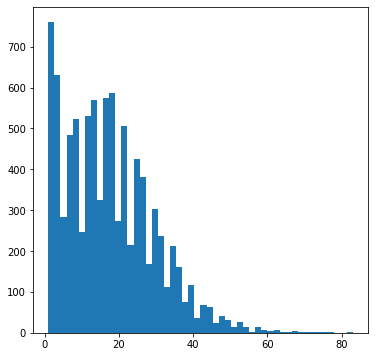

In [17]:
plt.figure(figsize=(6, 6))
plt.hist([len(s) for s in full_bin_dataset], bins=50)
plt.show

## Save preprocessed dataset

Finally, I **save the preprocess results**, so I can use it in the next steps (to train a model).

In [18]:
NEW_LINE_CHAR = "\n"
STR_JOIN_CHAR = ' '

corpus_train_file = 'corpus_train.txt'
corpus_test_file = 'corpus_test.txt'
bin_corpus_train_file = 'bin_corpus_train.txt'
bin_corpus_test_file = 'bin_corpus_test.txt'

PARSED_DATA_PATH = DATA_PATH + 'parsed/'
if not os.path.exists(PARSED_DATA_PATH):
    os.mkdir(PARSED_DATA_PATH)

# Store full parsed texts
with open(PARSED_DATA_PATH + corpus_train_file, 'w') as fp:
    fp.write(NEW_LINE_CHAR.join(train_dataset))

with open(PARSED_DATA_PATH + corpus_test_file, 'w') as fp:
    fp.write(NEW_LINE_CHAR.join(test_dataset))

# Store corpus as 1s and 0s
with open(PARSED_DATA_PATH + bin_corpus_train_file, 'w') as fp:
    bin_lines = [STR_JOIN_CHAR.join(t.astype('str')) for t in bin_train_dataset]
    fp.write(NEW_LINE_CHAR.join(bin_lines))

with open(PARSED_DATA_PATH + bin_corpus_test_file, 'w') as fp:
    bin_lines = [STR_JOIN_CHAR.join(t.astype('str')) for t in bin_test_dataset]
    fp.write(NEW_LINE_CHAR.join(bin_lines))